# Introduction
<hr style="border:2px solid black"> </hr>


**What?** How to tune your model with quantile loss function



# Import modules
<hr style="border:2px solid black"> </hr>

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from pprint import pprint
from sklearn.base import clone
rcParams['figure.figsize'] = 16, 8
rcParams['font.size'] = 20

In [2]:
# the mean_pinball_loss was available only in the dev version
import sklearn
sklearn.__version__

'1.0.dev0'

# Helper functions
<hr style="border:2px solid black"> </hr>

In [3]:
def highlightMin(x):
    x_min = x.min()
    return ['background: yellow' if v == x_min else '' for v in x]

def boldMin(x):
    x_min = x.min()
    return ['font-weight: bold' if v == x_min else '' for v in x]

# Create a test function & dataset
<hr style="border:2px solid black"> </hr>


- To make the problem interesting, we generate observations of the target y as the sum of a deterministic term computed by the function f and a random noise term that follows a centered log-normal. 
- To make this even more interesting we consider the case where the amplitude of the noise depends on the input variable x (heteroscedastic noise).
- The lognormal distribution is non-symmetric and long tailed: observing large outliers is likely but it is impossible to observe small outliers.    



In [4]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)


rng = np.random.RandomState(42)
X = np.atleast_2d(rng.uniform(0, 10.0, size=1000)).T
expected_y = f(X).ravel()

In [5]:
sigma = 0.5 + X.ravel() / 10
noise = rng.lognormal(sigma=sigma) - np.exp(sigma ** 2 / 2)
y = expected_y + noise

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# Create an evenly spaced evaluation set of input values spanning the [0, 10] range.
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T

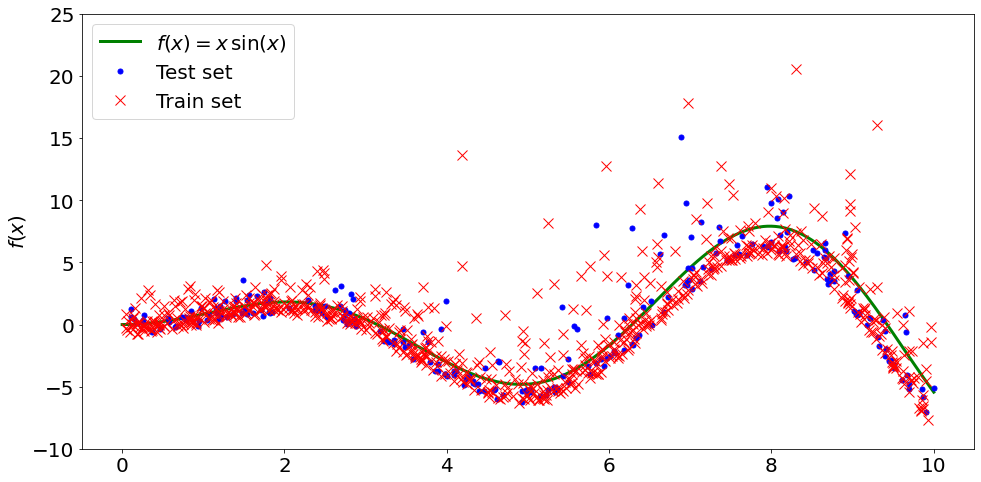

In [7]:
fig = plt.figure()
plt.plot(xx, f(xx), 'g-', lw =3, label = r'$f(x) = x\,\sin(x)$')
plt.plot(X_test, y_test, 'b.', markersize = 10, label = 'Test set')
plt.plot(X_train, y_train, 'rx', markersize = 10, lw = 1, label = 'Train set')

plt.ylabel('$f(x)$')
plt.ylim(-10, 25)
plt.legend(loc='upper left')
plt.show()

# Fitting non-linear quantile and least squares regressors
<hr style="border:2px solid black"> </hr>


- Fit gradient boosting models trained with the quantile loss and alpha=0.05, 0.5, 0.95.
- The models obtained for alpha=0.05 and alpha=0.95 produce a 90% confidence level (95% - 5% = 90%).
- The model trained with alpha=0.5 produces a regression of the median.
- The **medain** splits the data on average in a way that there should be the same number of target observations above and below the predicted values.
- To get the mean prediction we also fit a model trained with the usual (mean) squared error (MSE).



In [8]:
all_models = {}
common_params = dict(
    learning_rate=0.05,
    n_estimators=250,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)

for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(loss = 'quantile', alpha=alpha, **common_params)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)    

In [9]:
gbr_ls = GradientBoostingRegressor(loss='squared_error', **common_params)
all_models["mse"] = gbr_ls.fit(X_train, y_train)

In [10]:
# Get the keys from the dictionary
all_models.keys()

dict_keys(['q 0.05', 'q 0.50', 'q 0.95', 'mse'])

# First post-processing
<hr style="border:2px solid black"> </hr>


- Also observe that the inductive bias of gradient boosting trees is unfortunately preventing our 0.05 quantile to fully capture the sinoisoidal shape of the signal, in particular around x=8. 
- Tuning hyper-parameters **can reduce** this effect as shown in the last part of this notebook.
- Look at the test for: meanInOrIOut & medianInOrOut



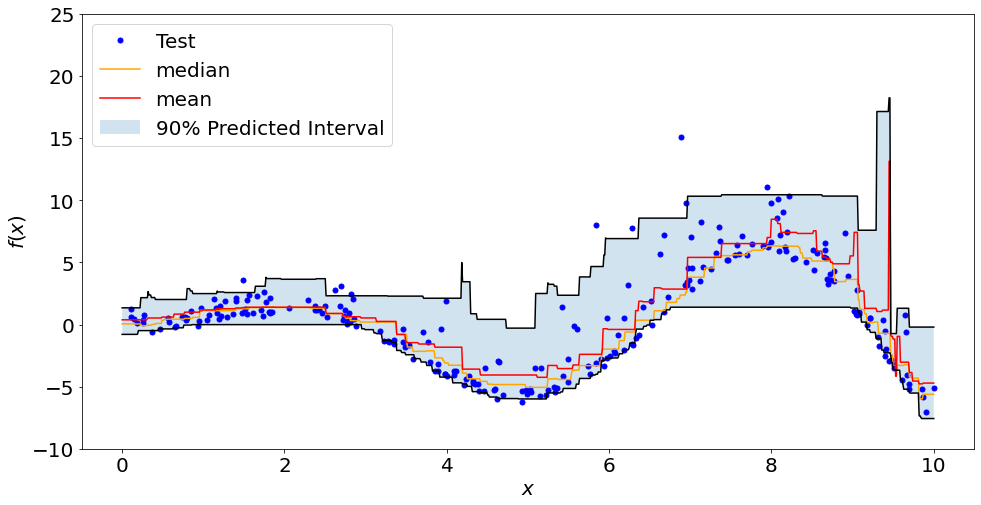

In [11]:
y_pred = all_models['mse'].predict(xx)

y_lower = all_models['q 0.05'].predict(xx)
y_upper = all_models['q 0.95'].predict(xx)
y_med = all_models['q 0.50'].predict(xx)

fig = plt.figure()
plt.plot(X_test, y_test, 'b.', markersize=10, label = 'Test')

plt.plot(xx, y_med, 'r-', label = 'median', color="orange")
plt.plot(xx, y_pred, 'r-', label = 'mean')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')

plt.fill_between(xx.ravel(), y_lower, y_upper, alpha = 0.2,
                 label = '90% Predicted Interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 25)
plt.legend(loc='upper left')
plt.show()

In [12]:
predictions = pd.DataFrame()
predictions["ID"] = np.arange(len(xx))

# No tuning
predictions['low'] = y_lower
predictions['mean'] = y_pred
predictions['med'] = y_med
predictions['up'] = y_upper

predictions['up>low'] = predictions['up'] > predictions['low']
predictions['med<up'] = predictions['med'] < predictions['up']
predictions['med>low'] = predictions['med'] > predictions['low']
predictions["meanInOrOut"] = (predictions['up'] > predictions['mean']) & (predictions['mean'] > predictions['low'])
predictions["width"] = abs(predictions['up'] - predictions['low'])


In [13]:
predictions.head(5)

,ID,low,mean,med,up,up>low,med<up,med>low,meanInOrOut,width
0,0,-0.790442,0.38205,0.055162,1.345719,True,True,True,True,2.136161
1,1,-0.790442,0.38205,0.055162,1.345719,True,True,True,True,2.136161
2,2,-0.790442,0.38205,0.055162,1.345719,True,True,True,True,2.136161
3,3,-0.790442,0.38205,0.055162,1.345719,True,True,True,True,2.136161
4,4,-0.790442,0.38205,0.055162,1.345719,True,True,True,True,2.136161


In [14]:
# Are there any nonses?
predictions[predictions["up>low"] == False]

,ID,low,mean,med,up,up>low,med<up,med>low,meanInOrOut,width


In [15]:
predictions[predictions["meanInOrOut"] == False]

,ID,low,mean,med,up,up>low,med<up,med>low,meanInOrOut,width
952,952,-3.675547,-4.155042,-3.28218,-0.72541,True,True,True,False,2.950137
953,953,-3.675547,-4.155042,-3.28218,-0.72541,True,True,True,False,2.950137


In [16]:
predictions[predictions["med<up"] == False]

,ID,low,mean,med,up,up>low,med<up,med>low,meanInOrOut,width


In [17]:
predictions[predictions["med>low"] == False]

,ID,low,mean,med,up,up>low,med<up,med>low,meanInOrOut,width


# Analysis of the error metrics
<hr style="border:2px solid black"> </hr>


- We'll start from the **training set**
- The minimum number on a column should be obtained when the model is trained and measured with the same metric. 
- This should be always the case on the training set if the training converged.
- The target distribution is asymmetric, thus mean and median are signficiantly different.
- Importanlty, one **could not** use the MSE to get a good estimation of the median nor the converse.
- If the target distribution were symmetric and had no outliers (e.g. with a Gaussian noise), then median estimator and the MSE would have yielded similar predictions.
- The **pinball loss** function is a metric used to assess the accuracy of a quantile forecast. 
- Indeed, contrary to the classic forecasts where the goal is to have the forecast as close as possible from the observed values, the situation is biased (on purpose) when it comes to quantile forecasts.



In [18]:
results = []
for name, gbr in sorted(all_models.items()):
    metrics = {'model': name}
    y_pred = gbr.predict(X_train)
    for alpha in [0.05, 0.5, 0.95]:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(y_train, y_pred, alpha=alpha)
    
    metrics['MSE'] = mean_squared_error(y_train, y_pred)
    results.append(metrics)

pd.DataFrame(results).set_index('model').style.apply(highlightMin).apply(boldMin)

,pbl=0.05,pbl=0.50,pbl=0.95,MSE
model,,,,
mse,0.706216,0.706216,0.706216,7.374961
q 0.05,0.112202,1.106613,2.101025,16.420012
q 0.50,0.297918,0.618546,0.939173,9.808202
q 0.95,3.829411,2.103431,0.377451,28.106030



- We'll then proceed to do the same on the **test set.**
- Errors are higher for q=5% meaning the models slightly overfitted the data. 
- It still shows that the best test metric is obtained when the model is trained by minimizing this same metric.
- Note that the conditional median estimator is competitive with the squared error estimator in terms of MSE on the test set: this can be explained by the fact the squared error estimator is very sensitive to large outliers which can cause significant overfitting. This can be seen on the right hand side of the previous plot. The conditional median estimator is biased (underestimation for this asymetric noise) but is also naturally robust to outliers and overfits less.



In [19]:
results = []
for name, gbr in sorted(all_models.items()):
    metrics = {'model': name}
    y_pred = gbr.predict(X_test)
    for alpha in [0.05, 0.5, 0.95]:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(
            y_test, y_pred, alpha=alpha)
    
    metrics['MSE'] = mean_squared_error(y_test, y_pred)
    results.append(metrics)

pd.DataFrame(results).set_index('model').style.apply(highlightMin).apply(boldMin)

,pbl=0.05,pbl=0.50,pbl=0.95,MSE
model,,,,
mse,0.933180,0.772983,0.612786,7.011503
q 0.05,0.133308,1.078019,2.022731,12.624741
q 0.50,0.408773,0.607041,0.805309,5.842858
q 0.95,4.284478,2.319882,0.355287,34.343416


# Calibration of the confidence interval
<hr style="border:2px solid black"> </hr>


- We can also evaluate the ability of the two extreme quantile estimators at producing a well-calibrated conditational 90%-confidence interval.
- To do this we can compute the fraction of observations that fall between the predictions using the **coverage_fraction**.
    1. On the **training set** the calibration is very close to the expected coverage value for a 90% confidence interval.
    - On the **test set**, the estimated confidence interval is slightly too narrow. 
    
- Note, however, that we would need to wrap those metrics in a cross-validation loop to assess their variability under data resampling.



In [20]:
def coverage_fraction(y, y_low, y_high):
    return np.mean(np.logical_and(y >= y_low, y <= y_high))

In [21]:
coverage_fraction(y_train,
                  all_models['q 0.05'].predict(X_train),
                  all_models['q 0.95'].predict(X_train))

0.9026666666666666

In [22]:
coverage_fraction(y_test,
                  all_models['q 0.05'].predict(X_test),
                  all_models['q 0.95'].predict(X_test))

0.84


- What is reported above is the same thing as the one below? Yes! See below. 
- [More important] **PI coverage probability (PICP)** is measured by counting the number of target values covered by the constructed PIs, where where ntest is the number of samples in the test set 
- [Less important] PICP has a direct relationship with the width of PIs. A satisfactorily large PICP can be easily achieved by widening PIs from either side. However, such PIs are too conservative and less useful in practice, as they do not show the variation of the targets. Therefore, a measure is required to check how wide the PIs are. **Mean PI width (MPIW)** quantifies this aspect. 



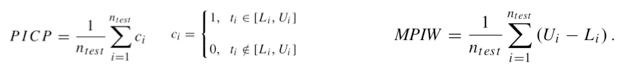

In [23]:
predictions1 = pd.DataFrame()
predictions1["ID"] = np.arange(len(X_test))

# No tuning
predictions1['low'] = all_models['q 0.05'].predict(X_test)
predictions1['test'] = y_test
predictions1['up'] = all_models['q 0.95'].predict(X_test)
predictions1["inOrOut"] = (predictions1['up'] > predictions1['test']) & (predictions1['test'] > predictions1['low'])


In [24]:
predictions1.head(5)

,ID,low,test,up,inOrOut
0,0,-2.904019,-2.769512,4.669224,True
1,1,-0.262810,-0.225501,2.017531,True
2,2,-2.025049,3.177087,6.918558,True
3,3,-4.795195,-0.393051,2.357840,True
4,4,-0.042736,0.543454,2.889332,True


In [25]:
# Are these the same thing PICP (Prediction Interval Coverage Probability)? Yes they are!
print("PICP : ", len(predictions1[predictions1['inOrOut'] == True])/ len(predictions1['inOrOut']) * 100)

PICP :  84.0


# Tuning the hyper-parameters of the quantile regressors
<hr style="border:2px solid black"> </hr>


- In the plot above, we observed that the 5th percentile regressor seems to underfit and could not adapt to sinusoidal shape of the signal.
- The hyper-parameters of the model were applied to both, lower, median, upper and mean. 
- **However**, there is no reason they should be the same.
- Let's tune (via cross-validation) the lower bound regressor on the pinball loss.



In [26]:
param_grid = dict(
    learning_rate=[0.01, 0.05, 0.1],
    n_estimators=[100, 150, 200, 250, 300],
    max_depth=[2, 5, 10, 15, 20],
    min_samples_leaf=[1, 5, 10, 20, 30, 50],
    min_samples_split=[2, 5, 10, 20, 30, 50],
)
alpha = 0.05
neg_mean_pinball_loss_05p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=alpha,
    greater_is_better=False,  # maximize the negative loss
)
gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, random_state=0)
search_05p = RandomizedSearchCV(
    gbr,
    param_grid,
    n_iter=10,  # increase this if computational budget allows
    scoring=neg_mean_pinball_loss_05p_scorer,
    n_jobs = -1,
    random_state=0,
).fit(X_train, y_train)

pprint(search_05p.best_params_)

{'learning_rate': 0.1,
 'max_depth': 20,
 'min_samples_leaf': 30,
 'min_samples_split': 5,
 'n_estimators': 200}



- We observe that the search procedure identifies that deeper trees are needed to get a good fit for the 5th percentile regressor. 
- Deeper trees are more expressive and less likely to underfit **but** more likely to overfit!
- Let’s now tune the hyper-parameters for the 95th percentile regressor. 
- We need to redefine the scoring metric used to select the best model, along with adjusting the alpha parameter of the inner gradient boosting estimator itself.



In [27]:
alpha = 0.95
neg_mean_pinball_loss_95p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=alpha,
    greater_is_better=False,  # maximize the negative loss
)

search_95p = clone(search_05p).set_params(
    estimator__alpha=alpha,
    scoring=neg_mean_pinball_loss_95p_scorer,
)

search_95p.fit(X_train, y_train)
pprint(search_95p.best_params_)

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 50,
 'n_estimators': 250}



- This time, shallower trees are selected and lead to a more constant piecewise and therefore more robust estimation of the 95th percentile. 
- This is beneficial as it avoids overfitting the large outliers of the log-normal additive noise. 



# Post-processing the optimal results
<hr style="border:2px solid black"> </hr>

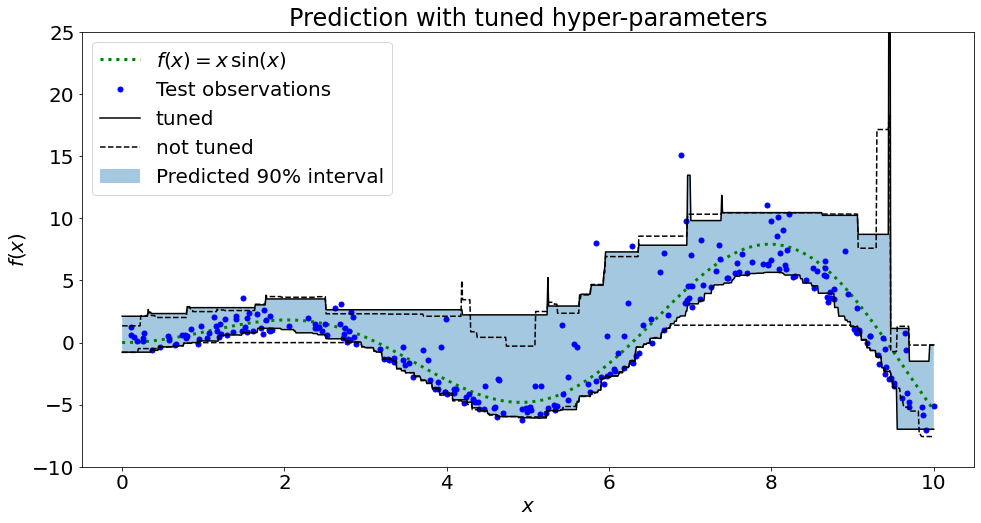

In [28]:
y_lower_tuned = search_05p.predict(xx)
y_upper_tuned = search_95p.predict(xx)

fig = plt.figure()
plt.plot(xx, f(xx), 'g:', linewidth=3, label=r'$f(x) = x\,\sin(x)$')
plt.plot(X_test, y_test, 'b.', markersize=10, label='Test observations')
plt.plot(xx, y_upper_tuned, 'k-', label = "tuned")
plt.plot(xx, y_lower_tuned, 'k-')

plt.plot(xx, y_upper, 'k--', label = "not tuned")
plt.plot(xx, y_lower, 'k--')

plt.fill_between(xx.ravel(), y_lower_tuned, y_upper_tuned, alpha=0.4,
                 label='Predicted 90% interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 25)
plt.legend(loc='upper left')
plt.title("Prediction with tuned hyper-parameters")
plt.show()

In [29]:
coverage_fraction(y_train,
                  search_05p.predict(X_train),
                  search_95p.predict(X_train))

0.8986666666666666

In [30]:
coverage_fraction(y_test,
                  search_05p.predict(X_test),
                  search_95p.predict(X_test))

0.768


- The plot looks qualitatively better than for the untuned models, especially for the shape of the of lower quantile.
- The calibration of the tuned pair is sadly not better on the test set: the width of the estimated confidence interval is still **too narrow.**
- Again, we would need to wrap this study in a cross-validation loop to better assess the variability of those estimates.



In [31]:
# No tuning
predictions['lower_tuned'] = y_lower_tuned
predictions['upper_tuned'] = y_upper_tuned

predictions['upper_tuned>lower_tuned'] = predictions['upper_tuned'] > predictions['lower_tuned']
predictions['median_tuned<upper_tuned'] = predictions['med'] < predictions['upper_tuned']
predictions['median_tuned>lower_tuned'] = predictions['med'] > predictions['lower_tuned']
predictions["meanInOrOut_tuned"] = (predictions['upper_tuned'] > predictions['mean']) & (predictions['mean'] > predictions['lower_tuned'])
predictions["width_tuned"] = abs(predictions['upper_tuned'] - predictions['lower_tuned'])

In [32]:
predictions[predictions["meanInOrOut_tuned"] == False]

,ID,low,mean,med,up,up>low,med<up,med>low,meanInOrOut,width,lower_tuned,upper_tuned,upper_tuned>lower_tuned,median_tuned<upper_tuned,median_tuned>lower_tuned,meanInOrOut_tuned,width_tuned
952,952,-3.675547,-4.155042,-3.28218,-0.72541,True,True,True,False,2.950137,-3.687721,1.137376,True,True,True,False,4.825098
953,953,-3.675547,-4.155042,-3.28218,-0.72541,True,True,True,False,2.950137,-3.687721,1.137376,True,True,True,False,4.825098


In [33]:
predictions[predictions['median_tuned>lower_tuned'] == False]

,ID,low,mean,med,up,up>low,med<up,med>low,meanInOrOut,width,lower_tuned,upper_tuned,upper_tuned>lower_tuned,median_tuned<upper_tuned,median_tuned>lower_tuned,meanInOrOut_tuned,width_tuned



- The coverage has **NOT** improved.
- There are still 2 points that are not within the PI.
- The model is not perfect and we have to live with it.



# Conclusion
<hr style="border:2px solid black"> </hr>


- When the quantile loss function, you need to calibrate the regressor with the appropriate metrics.
- Even in the case of **calibrated** regressor, it is seems that it is dificult to converge this objective function.
- MSE is **no-longer** valid as a metric when data are not normally dsitributed.



# References
<hr style="border:2px solid black"> </hr>


- https://scikit-learn.org/dev/auto_examples/ensemble/plot_gradient_boosting_quantile.html<br>

